## Gas Turbine Health Monitoring

This work uses the dataset generated by Chao et al 2021.

ARIAS CHAO, Manuel et al. Aircraft engine run-to-failure dataset under real flight conditions for prognostics and diagnostics. Data, v. 6, n. 1, p. 5, 2021.

My goal is to apply machine learning to predict gas turbine degratation and estimate remaining useful life.

In [1]:
import math
import pandas as pd
import h5py

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score
%matplotlib inline
sns.set()

In [2]:
filename = 'N-CMAPSS_DS05.h5'

location = "/Users/krul/Downloads/17. Turbofan Engine Degradation Simulation Data Set 2/data_set/"

file_location = location + filename

In [3]:
with h5py.File(file_location, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


W shape: (6912652, 4)
X_s shape: (6912652, 14)
X_v shape: (6912652, 14)
T shape: (6912652, 10)
A shape: (6912652, 4)


In [27]:
df_A = pd.DataFrame(data=A, columns=A_var)
df_A.describe()

,unit,cycle,Fc,hs
count,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06
mean,5.239374e+00,4.002810e+01,2.226115e+00,2.958030e-01
std,2.904136e+00,2.368351e+01,8.078304e-01,4.564029e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.900000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.900000e+01,3.000000e+00,1.000000e+00
max,1.000000e+01,1.000000e+02,3.000000e+00,1.000000e+00


In [28]:
print('Engine units in df: ', np.unique(df_A['unit']))

Engine units in df:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


## End of Failure ($t_{\text{EOF}}$)
The run to failure operation take a different number of cycles for each unit. Below we report the total number of cycles for each unit.

In [32]:
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_{EOF}): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    #np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])

Unit: 1.0 - Number of flight cyles (t_{EOF}):  80
Unit: 2.0 - Number of flight cyles (t_{EOF}):  80
Unit: 3.0 - Number of flight cyles (t_{EOF}):  65
Unit: 4.0 - Number of flight cyles (t_{EOF}):  99
Unit: 5.0 - Number of flight cyles (t_{EOF}):  100
Unit: 6.0 - Number of flight cyles (t_{EOF}):  67
Unit: 7.0 - Number of flight cyles (t_{EOF}):  85
Unit: 8.0 - Number of flight cyles (t_{EOF}):  91
Unit: 9.0 - Number of flight cyles (t_{EOF}):  69
Unit: 10.0 - Number of flight cyles (t_{EOF}):  82


## Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [35]:
df_W = pd.DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values

In [37]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [39]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

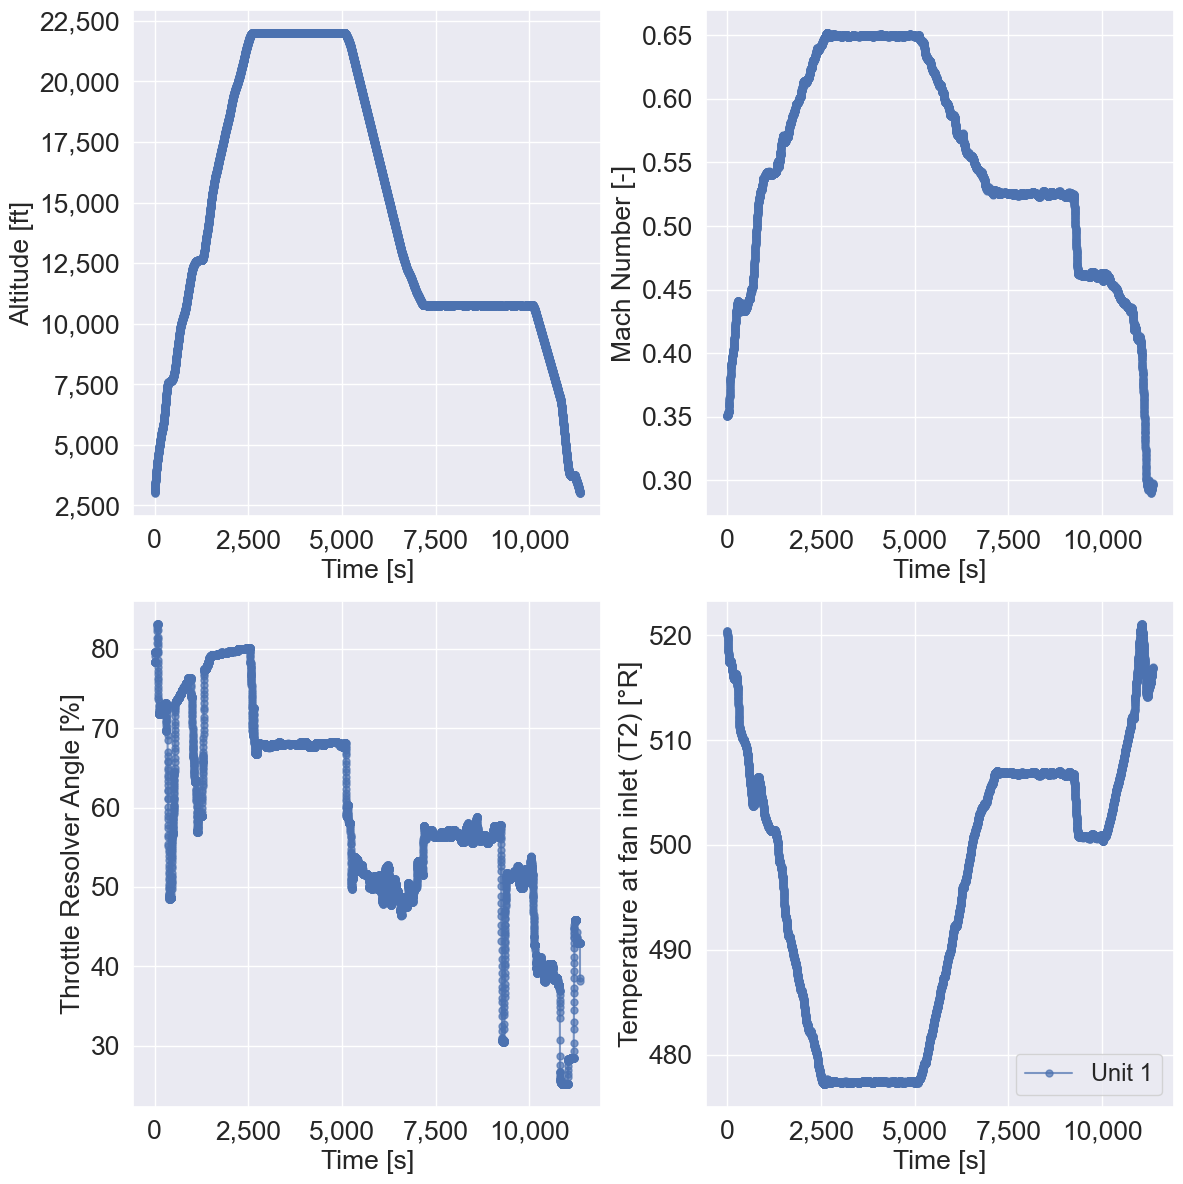

In [41]:
df_W_u = df_W.loc[(df_A.unit == 1) & (df_A.cycle == 4)]
df_W_u.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02.png')

### Histogram of Flight Conditions

In [43]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], fill=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

/Users/krul/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/krul/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/krul/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/krul/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

<Figure size 640x480 with 0 Axes>

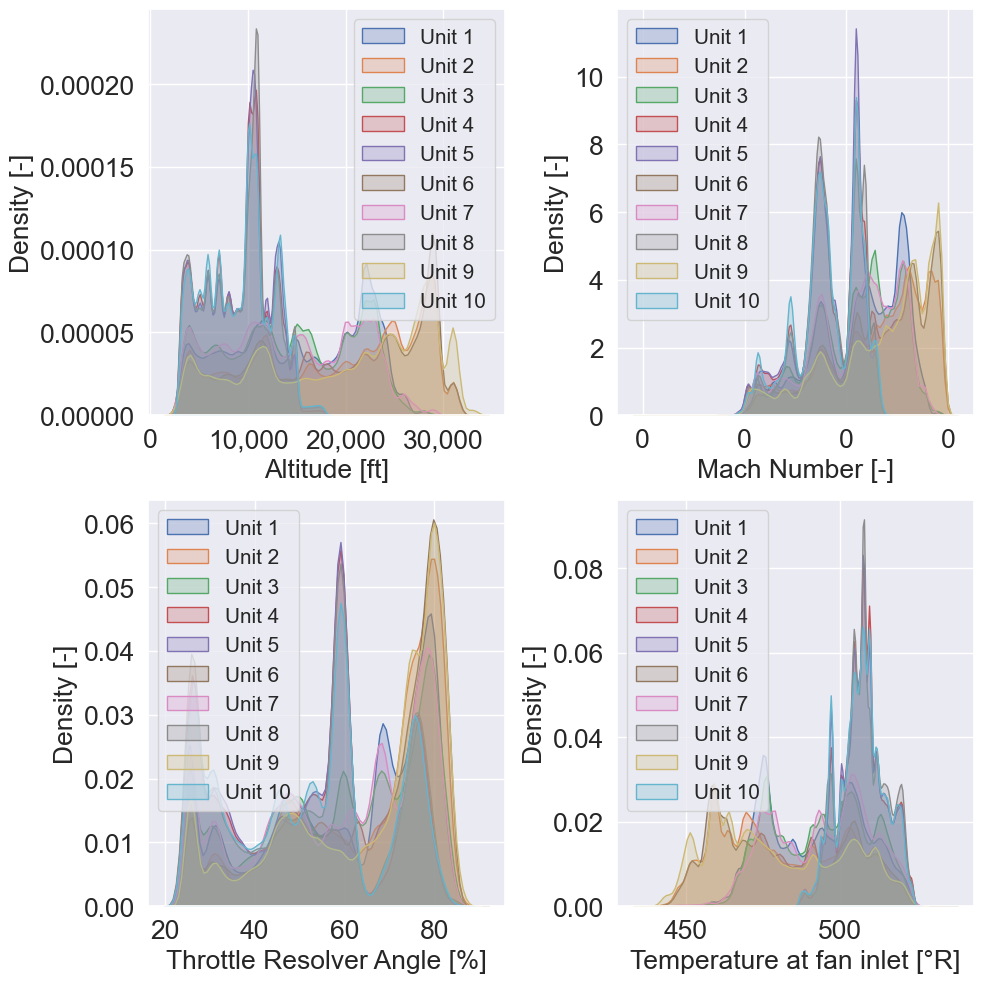

In [46]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df_A['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=19, name='kde_DS02.png')

## Degradation ($\theta$)

In [48]:
df_T = pd.DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_Ts = df_T.drop_duplicates()
df_Ts.describe()

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle
count,818.0,818.0,818.0,818.0,818.000000,818.000000,818.0,818.0,818.0,818.0,818.000000,818.000000
mean,0.0,0.0,0.0,0.0,-0.004007,-0.006234,0.0,0.0,0.0,0.0,5.497555,42.251834
std,0.0,0.0,0.0,0.0,0.004909,0.010509,0.0,0.0,0.0,0.0,2.828534,25.059736
min,0.0,0.0,0.0,0.0,-0.024471,-0.077919,0.0,0.0,0.0,0.0,1.000000,1.000000
25%,0.0,0.0,0.0,0.0,-0.005047,-0.006614,0.0,0.0,0.0,0.0,3.000000,21.000000
50%,0.0,0.0,0.0,0.0,-0.001762,-0.002083,0.0,0.0,0.0,0.0,5.000000,41.000000
75%,0.0,0.0,0.0,0.0,-0.000994,-0.001112,0.0,0.0,0.0,0.0,8.000000,62.000000
max,0.0,0.0,0.0,0.0,0.000067,-0.000081,0.0,0.0,0.0,0.0,10.000000,100.000000


<Figure size 640x480 with 0 Axes>

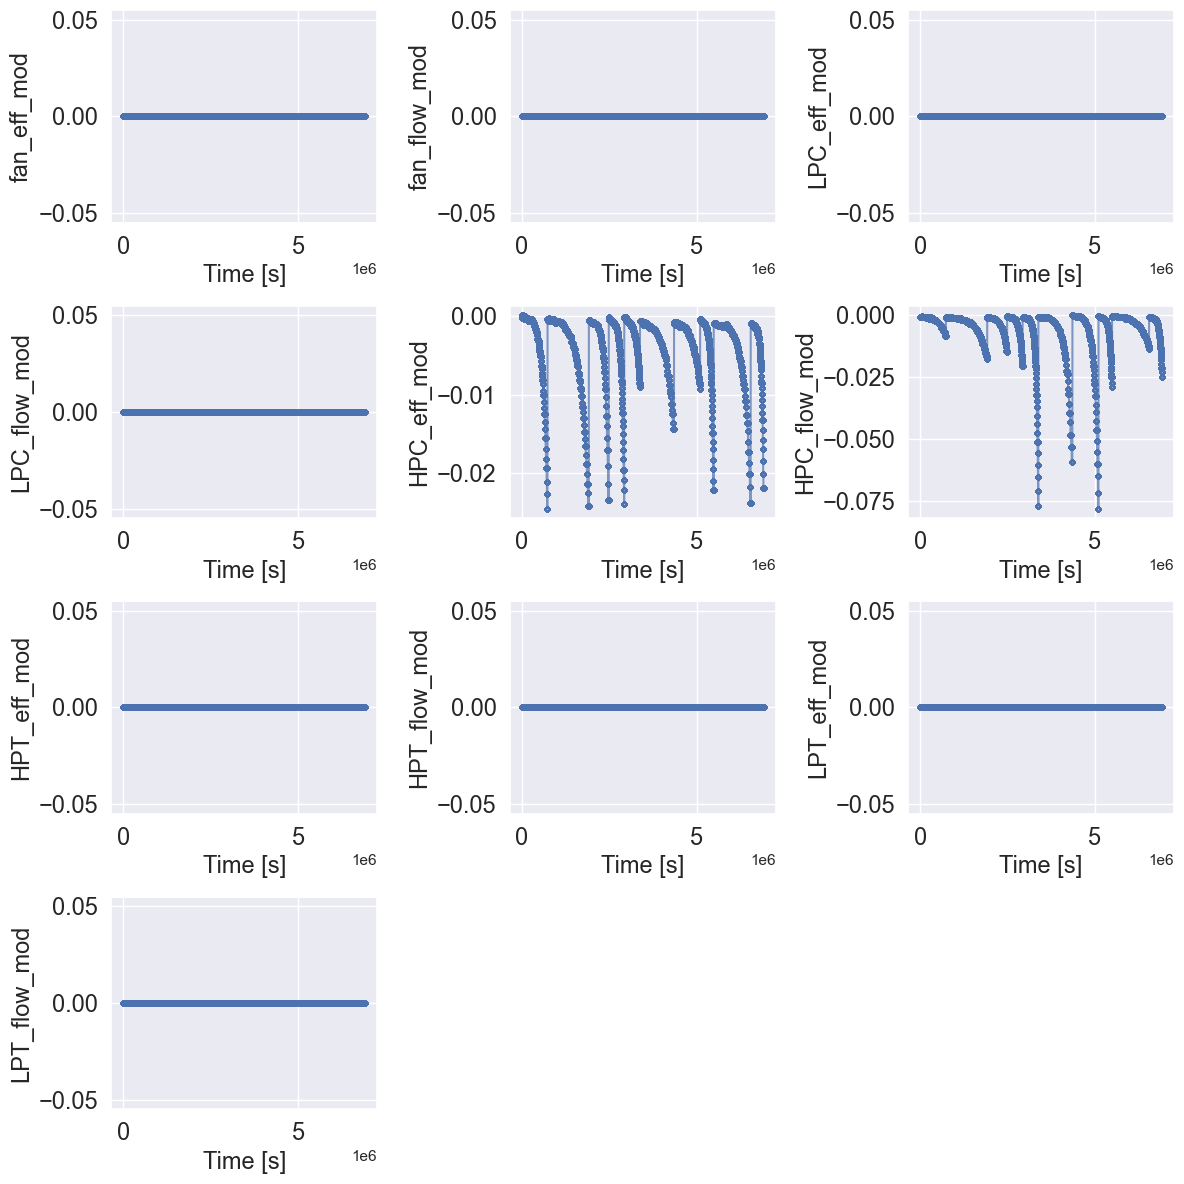

In [49]:
labels = T_var
plot_df_single_color(df_T, T_var , labels)

<Figure size 640x480 with 0 Axes>

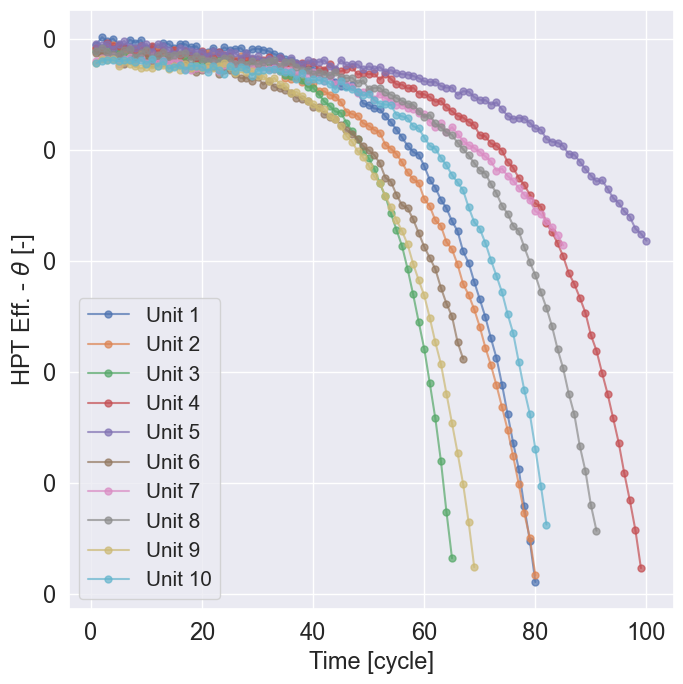

In [50]:
plot_df_color_per_unit(df_Ts, ['HPC_eff_mod'], [r'HPT Eff. - $\theta$ [-]'], size=7,  option='cycle')

## Sensor readings ($X_s$)

In [52]:
df_X_s = pd.DataFrame(data=X_s, columns=X_s_var) 

<Figure size 640x480 with 0 Axes>

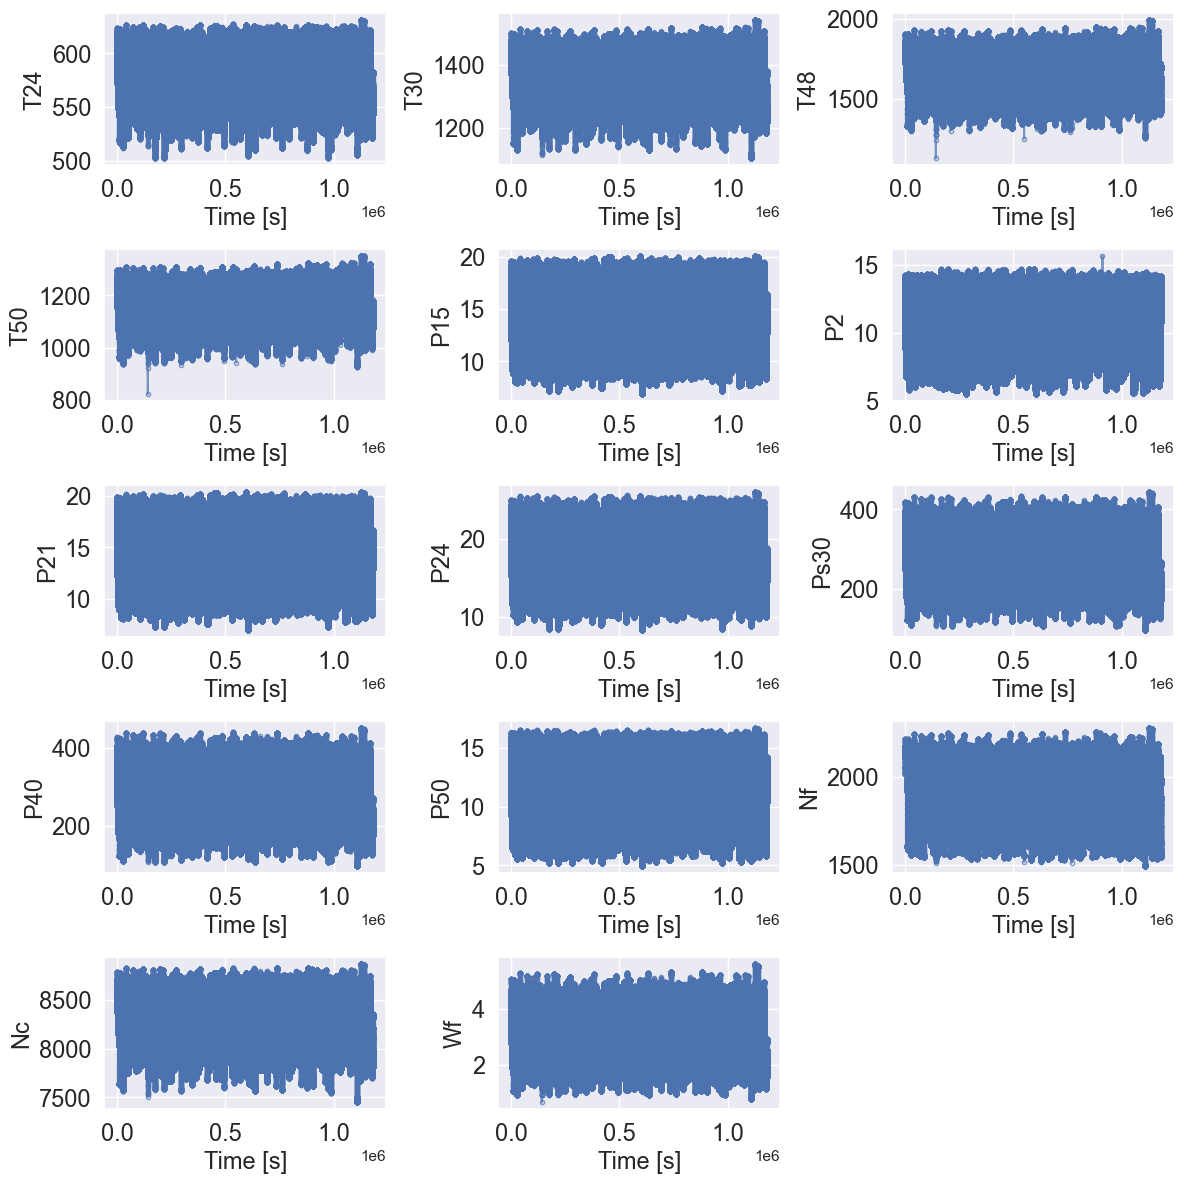

In [53]:
df_X_s_u = df_X_s.loc[df_A.unit == 2]
df_X_s_u.reset_index(inplace=True, drop=True)
labels = X_s_var
plot_df_single_color(df_X_s_u, X_s_var, labels)

## RUL

In [55]:
df_Y = pd.DataFrame(data=Y, columns=["RUL"])
df_Y['unit'] = df_A['unit'].values
df_Y['cycle'] = df_A['cycle'].values
df_Ys = df_Y.drop_duplicates()
df_Ys.describe()

,RUL,unit,cycle
count,818.000000,818.000000,818.000000
mean,41.251834,5.497555,42.251834
std,25.059736,2.828534,25.059736
min,0.000000,1.000000,1.000000
25%,20.000000,3.000000,21.000000
50%,40.000000,5.000000,41.000000
75%,61.000000,8.000000,62.000000
max,99.000000,10.000000,100.000000


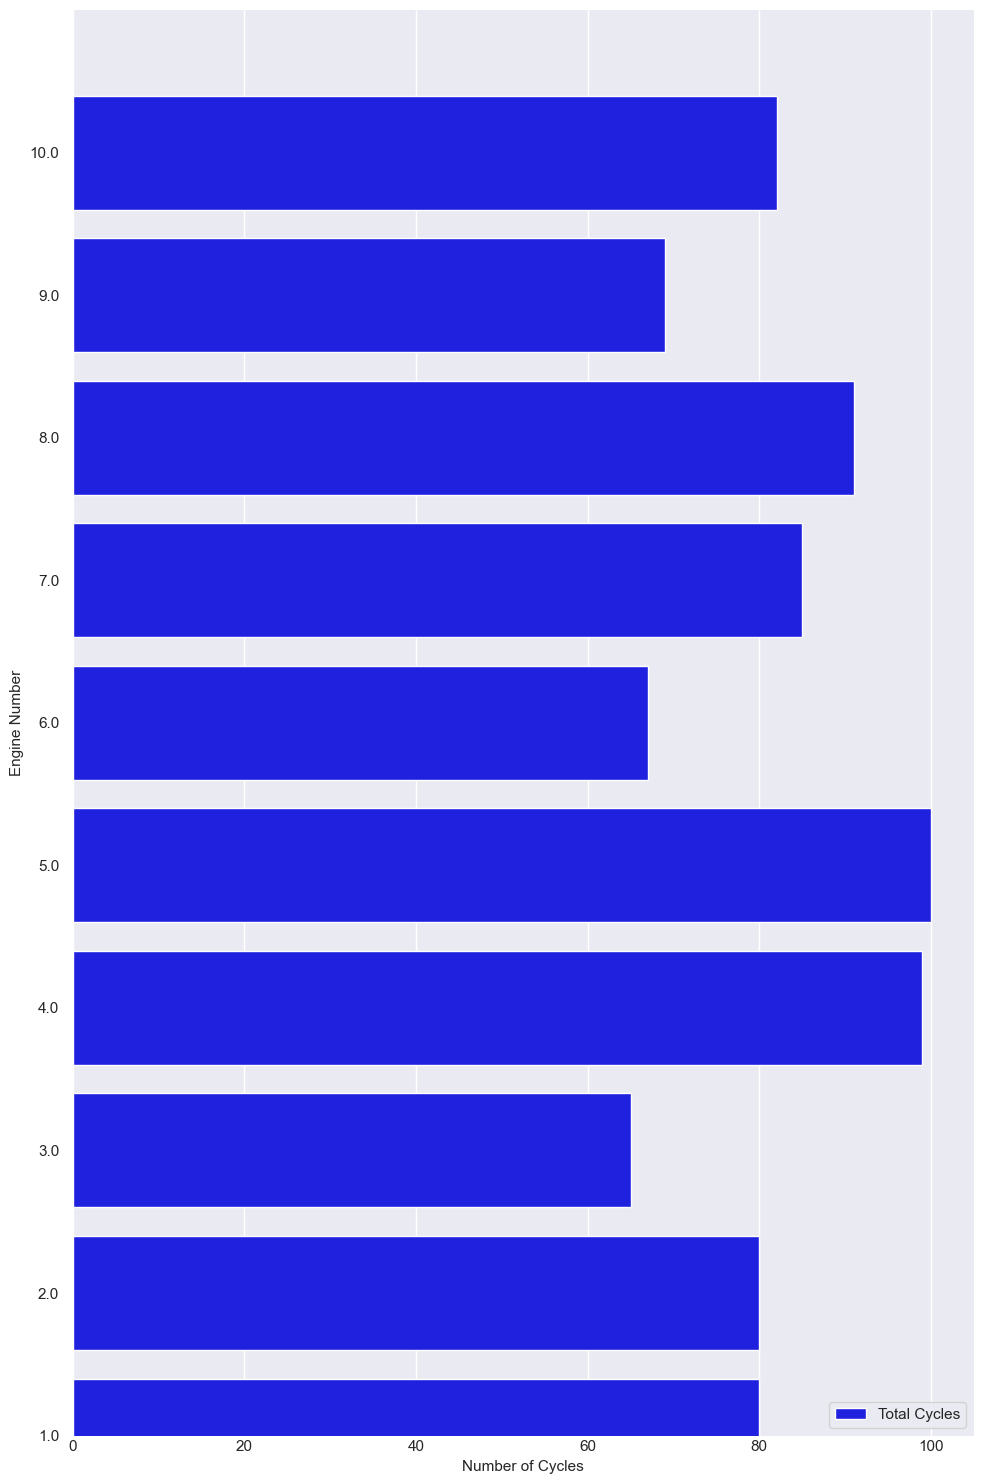

In [56]:
jet_id_and_rul = df_A.groupby(['unit'])[["unit" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="unit", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 10), ylabel="engine id",xlabel="Lifetime for each engine")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

In [57]:
df_W = df_W.reset_index() 
df_X_s = df_X_s.reset_index() 
df_merged = pd.merge(df_W, df_X_s, on='index')

In [58]:
df_Y = df_Y.reset_index() 

df_merged = pd.merge(df_merged, df_Y, on='index')

In [59]:
df_merged.head()

,index,alt,Mach,TRA,T2,unit_x,T24,T30,T48,T50,...,P24,Ps30,P40,P50,Nf,Nc,Wf,RUL,unit_y,cycle
0,0,3002.0,0.370377,81.122467,521.900827,1.0,628.067440,1511.513103,1926.925730,1305.942703,...,25.654299,433.588452,440.331422,16.506868,2240.817081,8822.782067,5.280657,79,1.0,1.0
1,1,3010.0,0.370818,81.122467,521.904702,1.0,628.055445,1511.458504,1926.939420,1305.955847,...,25.650603,433.502638,440.242970,16.503124,2240.682999,8822.565341,5.279919,79,1.0,1.0
2,2,3017.0,0.371259,81.122467,521.912580,1.0,628.062671,1511.447754,1926.891685,1305.888172,...,25.649811,433.463184,440.203438,16.499794,2240.711263,8822.534731,5.279245,79,1.0,1.0
3,3,3030.0,0.372078,81.122467,521.926210,1.0,628.074735,1511.440602,1926.851322,1305.806355,...,25.648417,433.407051,440.146929,16.494665,2240.760181,8822.512894,5.278388,79,1.0,1.0
4,4,3038.0,0.372519,81.122467,521.930527,1.0,628.077782,1511.400057,1926.753906,1305.700646,...,25.646643,433.331048,440.070597,16.489861,2240.761586,8822.386619,5.277163,79,1.0,1.0


In [61]:
df_T.head()

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle
0,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0


In [62]:
len(df_T)

6912652

In [63]:
df_T = df_T.reset_index() 

df_merged = pd.merge(df_merged, df_T, on='index')

In [64]:
df_merged.head()

,index,alt,Mach,TRA,T2,unit_x,T24,T30,T48,T50,...,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle_y
0,0,3002.0,0.370377,81.122467,521.900827,1.0,628.067440,1511.513103,1926.925730,1305.942703,...,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
1,1,3010.0,0.370818,81.122467,521.904702,1.0,628.055445,1511.458504,1926.939420,1305.955847,...,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
2,2,3017.0,0.371259,81.122467,521.912580,1.0,628.062671,1511.447754,1926.891685,1305.888172,...,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
3,3,3030.0,0.372078,81.122467,521.926210,1.0,628.074735,1511.440602,1926.851322,1305.806355,...,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0
4,4,3038.0,0.372519,81.122467,521.930527,1.0,628.077782,1511.400057,1926.753906,1305.700646,...,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,1.0,1.0


<Axes: >

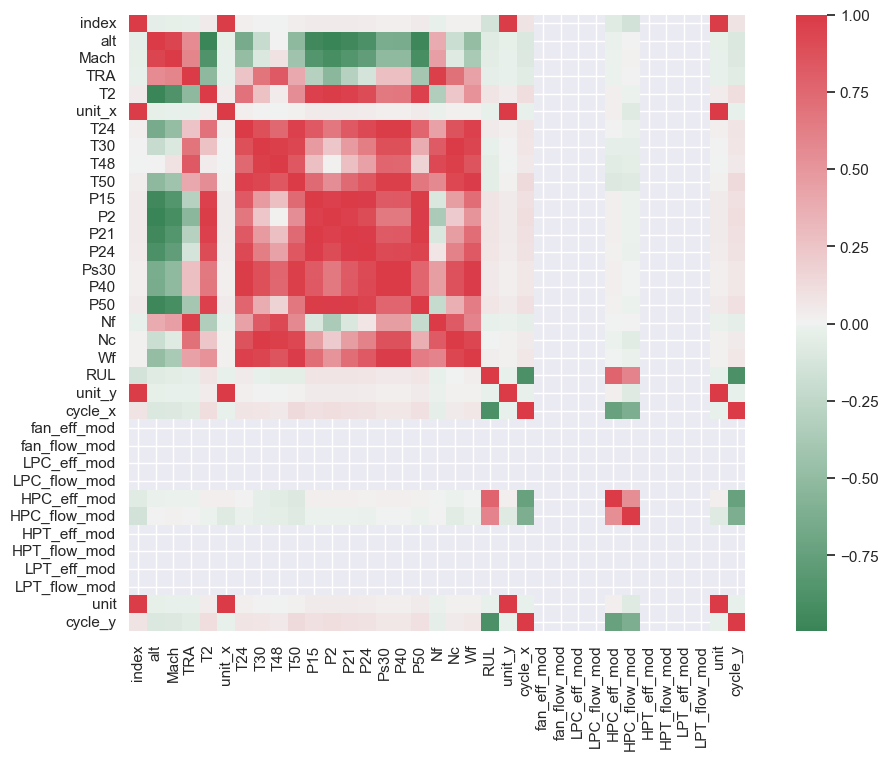

In [65]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(df_merged.corr(), cmap =cmap, center=0, annot=False, square=True)

In [66]:
df_X_v = pd.DataFrame(data=X_s, columns=X_s_var) 
df_X_v.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf
0,628.067440,1511.513103,1926.925730,1305.942703,20.030712,14.445617,20.335749,25.654299,433.588452,440.331422,16.506868,2240.817081,8822.782067,5.280657
1,628.055445,1511.458504,1926.939420,1305.955847,20.028054,14.444604,20.333050,25.650603,433.502638,440.242970,16.503124,2240.682999,8822.565341,5.279919
2,628.062671,1511.447754,1926.891685,1305.888172,20.027157,14.444141,20.332139,25.649811,433.463184,440.203438,16.499794,2240.711263,8822.534731,5.279245
3,628.074735,1511.440602,1926.851322,1305.806355,20.025641,14.443352,20.330600,25.648417,433.407051,440.146929,16.494665,2240.760181,8822.512894,5.278388
4,628.077782,1511.400057,1926.753906,1305.700646,20.023867,14.442366,20.328799,25.646643,433.331048,440.070597,16.489861,2240.761586,8822.386619,5.277163


In [67]:
df_X_v = df_X_v.reset_index()
sensor_merged = pd.merge(df_X_s, df_X_v, on='index')

In [68]:
sensor_eff = pd.merge(sensor_merged, df_T, on='index')

In [69]:
sensor_eff = sensor_eff.drop(columns=['fan_eff_mod','fan_flow_mod','LPC_eff_mod','LPC_flow_mod'])

<Axes: >

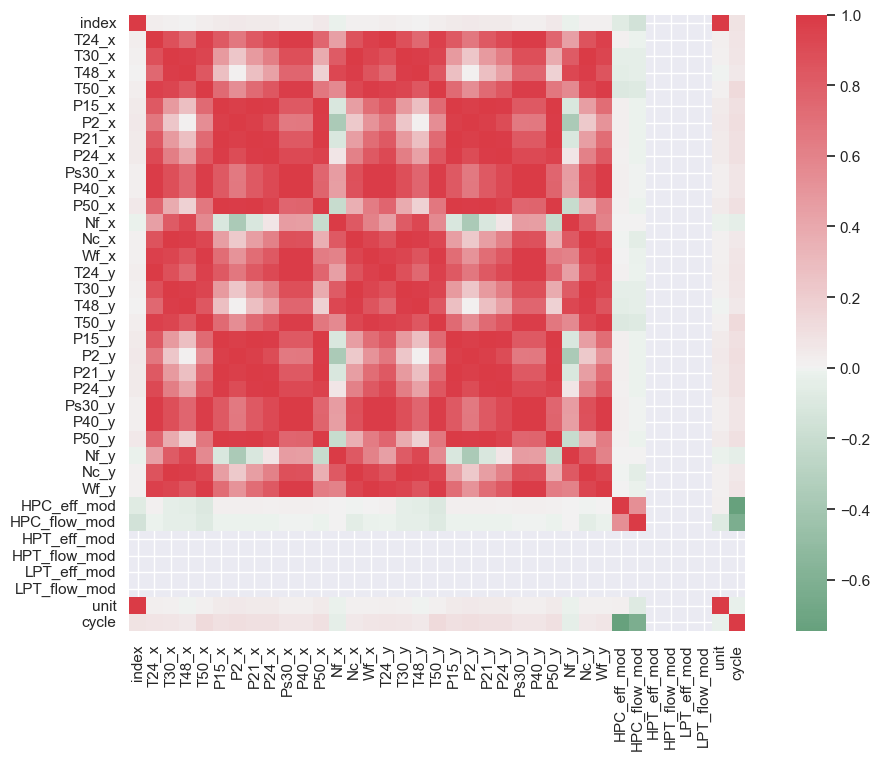

In [70]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(sensor_eff.corr(), cmap =cmap, center=0, annot=False, square=True)

## RUL Prediction

In [72]:
#next steps:
#1) criar modelo que preve eff e flow mod baseado nos parametros dos sensores e ambient conditions
#2) criar modelo que preve RUL a partir do eff e flow mod

In [73]:
X_train = pd.DataFrame(data=T_dev, columns=T_var)
y_train = pd.DataFrame(data=Y_dev, columns=["RUL"])

X_test = pd.DataFrame(data=T_test, columns=T_var)
y_test = pd.DataFrame(data=Y_test, columns=["RUL"])

In [74]:
X_train.head()

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0


In [75]:
y_train.head()

,RUL
0,79
1,79
2,79
3,79
4,79


In [76]:
len(y_train)

4350606

In [77]:
len(X_train)

4350606

In [78]:
len(X_test)

2562046

In [79]:
len(y_test)

2562046

In [81]:
cycles = 20
y_train['label'] = y_train['RUL'].apply(lambda x: 1 if x<=cycles else 0)
y_test['label'] = y_test['RUL'].apply(lambda x: 1 if x<=cycles else 0)

y_train = y_train['label']
y_test = y_test['label']

In [87]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

train_data = pd.merge(X_train, y_train, on='index')
test_data = pd.merge(X_test, y_test, on='index')

train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [89]:
y_train = train_data['label']
y_test = test_data['label']

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [127]:
X_train = train_data.drop(columns=['level_0_x','level_0_y','label','index'])
X_test = test_data.drop(columns=['level_0_x','level_0_y','label','index'])

In [129]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (4350606, 10)
X_test shape :  (2562046, 10)
y_train shape :  (4350606,)
y_test shape :  (2562046,)


In [125]:
X_train.head()

,index,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,label
0,0,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,0
1,1,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,0
2,2,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,0
3,3,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,0
4,4,0.0,0.0,0.0,0.0,-0.000261,-0.000613,0.0,0.0,0.0,0.0,0


In [93]:
#trabalhar pra reduzir os valores duplicados
#junta X com y e depois remove duplicados

### RandomForest

In [131]:
classifier = RandomForestClassifier(random_state=90, oob_score = False)

# Define the parameter Grid
params = {
 'max_depth': [18, 20, 22],
 'max_features': ['sqrt'],
 'min_samples_split': [22, 25],
 'min_samples_leaf': [12, 10, 8],
 'n_estimators': [20, 30, 40]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

0.874606449551439

In [ ]:
pred = grid_search.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.9629639748856968
Roc Auc Score:  0.9447585003342924
Precision Score:  0.9554993894733312
Recall Score:  0.9051314449923826
f1 score:  0.9296336780656232


<Figure size 1500x800 with 0 Axes>

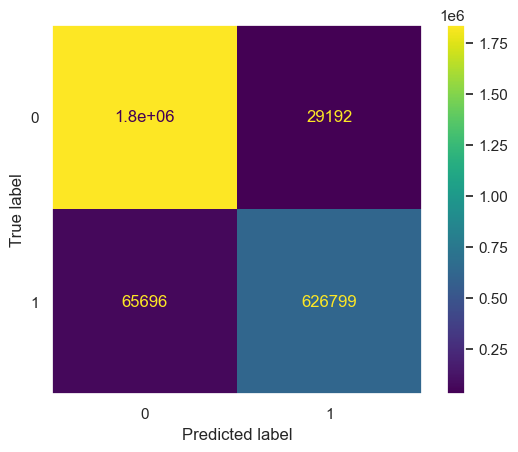

In [ ]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

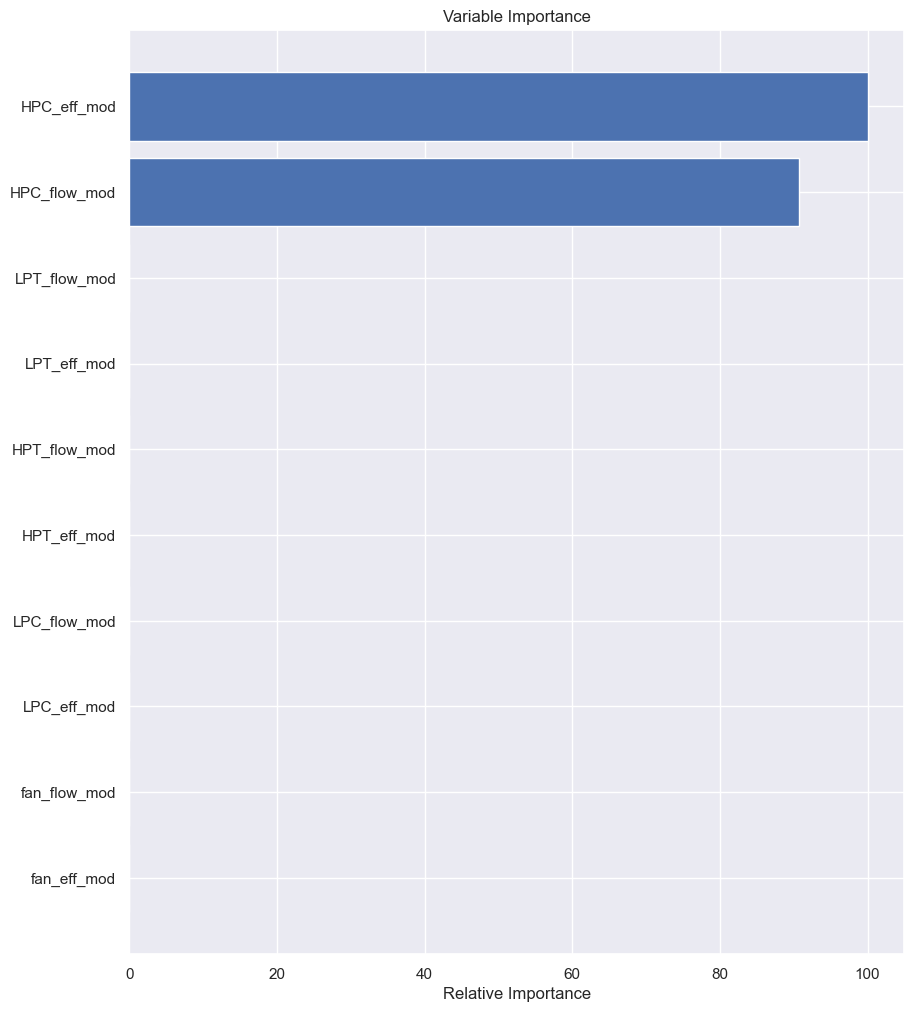

In [ ]:
best_model = grid_search.best_estimator_

# Plotting the Relative Importance as per tuned model
feature_importance = best_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Logistic regression

In [ ]:
lr_classifier = LogisticRegression()

# Define the parameter Grid
params = {
 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l2'],
 'C': [1.2, 1.5, 1.8]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=lr_classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

0.911391539114174

In [ ]:
pred = grid_search.predict(X_test)

print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.9568259117908109
Roc Auc Score:  0.9347481075868328
Precision Score:  0.9502475320305983
Recall Score:  0.8866923226882505
f1 score:  0.9173704725721125


<Figure size 1500x800 with 0 Axes>

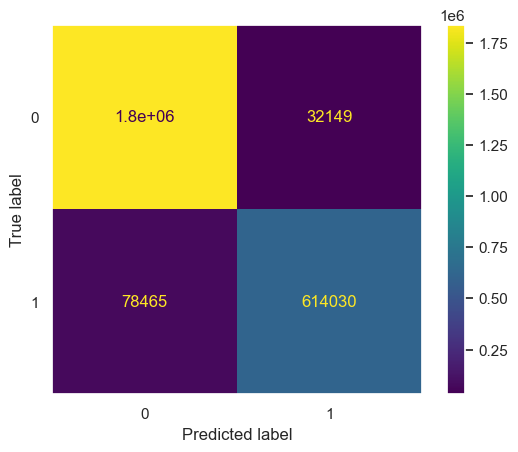

In [ ]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

### LGBM Classifier

In [ ]:
import lightgbm as lgb
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metrics='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, y_train)
lgb_clss.score(X_test, y_test)
preds2 = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2,average='binary'))

ModuleNotFoundError: No module named 'lightgbm'

### Randomized Search CV

In [ ]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1),
         'subsample': np.arange( 0.7, 1, 0.05),
         'gamma': np.arange(0.5, 1, 0.1),
         'colsample_bytree': np.arange( 0.1, 1, 0.05),
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rs_cv_classifier.classes_)
plt.title("Confusion Matrix")
plt.show()
